# Jupyter Notebook: Mapping Conditional Essentialities: A CRISPR Knockout Framework for Cancer Research

**Author(s):** 
- Anika Thatavarthy (GitHub: `AnikaTha`)
- Param Somane (GitHub: `ChestnutKurisu`)
- Andrii Dovhaniuk (GitHub: `Andreydovhaniuk`)
- Elizabeth Murphy (GitHub: `elizabethmurphy024`)

**Course:** MED 263 (Winter 2025)

---

## 0. Environment Setup

### 0.1 Clone the Repository

Run the cell below to clone your GitHub repository into the Colab environment.

In [ ]:
!git clone https://github.com/ChestnutKurisu/MED263_Final_Project_WI25.git

### 0.2 Install Dependencies

This cell installs the specific packages needed by your notebook.

In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2 seaborn==0.13.2 matplotlib==3.10.0 scipy==1.13.1 scikit-learn==1.6.1

---

## 1. Introduction & Background

Cancer research often leverages **CRISPR-Cas9** knockout screens to identify which genes are essential for tumor cell survival. By systematically disrupting genes, researchers can pinpoint vulnerabilities and potential therapeutic targets. However, CRISPR screens alone can be confounded by factors such as existing mutations or copy-number changes. To address this, we integrate **multi-omics** data—combining genomic and transcriptomic profiles—to better understand the context of each gene’s essentiality.

### 1.1 CRISPR-Cas9 at a Glance
- **Genome Editing**: CRISPR-Cas9 induces DNA double-strand breaks at specified genomic loci.
- **Knockout Screens**: By selectively disrupting genes across many cell lines, we can assess each gene’s impact on cell viability or proliferation.

### 1.2 Why Integrate Multi-Omics?
- **Mutation Confound**: If a tumor suppressor is already inactivated, CRISPR knockout may show little additional effect.
- **Copy-Number Confound**: High-level amplifications may appear more “essential” due to multiple CRISPR target sites.
- **Expression Confound**: A lowly expressed gene might show no effect when knocked out.  
Bringing in mutation status, copy number, and expression can reveal context-dependent (conditional) essentialities.

### 1.3 Project Aims
We aim to:
1. **Identify essential genes** across diverse cancer cell lines.
2. **Explore how mutation, copy number, and expression** influence CRISPR knockout phenotypes.
3. **Demonstrate** how integrated bioinformatics pipelines can refine gene essentiality predictions, with potential applications to precision oncology.

### 1.4 Import Libraries

In [52]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
from sklearn.metrics import  mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

----

## 2. Data Sources & Preparation

### 2.1 Data Loading & Cleaning

In [53]:
# Path to your local folder containing preprocessed DepMap CSVs
DATA_DIR = "DepMap-preprocessed"

1. **Model Metadata** (`Model.csv`)  
   - Contains **cell-line-level** descriptors (e.g., lineage, primary disease, subtype).  
   - Includes **Oncotree** annotations (e.g. `OncotreeLineage`), **CCLEName**, and other clinical/contextual fields for each model.

In [54]:
model_file = os.path.join(DATA_DIR, "Model.csv")
model_df = pd.read_csv(model_file)
model_df.head(3)

,ModelID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,...,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,Available in SRA,NaN,2201.0,SIDM00105,905933.0
1,ACH-000002,PT-5qa3uk,HL-60,HL60,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"TP53(del), CDKN2A and NRAS mutations [PubMed=2...",...,NaN,NaN,NaN,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,Available in SRA,NaN,55.0,SIDM00829,905938.0
2,ACH-000003,PT-puKIyc,CACO2,CACO2,COAD,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,COAD,NaN,...,NaN,NaN,NaN,CACO2_LARGE_INTESTINE,NaN,Available in SRA,NaN,NaN,SIDM00891,NaN


2. **Chronos Effect Score** (`CRISPRGeneEffect`):  
   - A negative score indicates that knocking out the gene reduces cell viability (i.e., more essential).  
   - Scores near zero or positive suggest little to no viability impact when that gene is disrupted.

In [55]:
gene_effect_file = os.path.join(DATA_DIR, "CRISPRGeneEffect.csv")
gene_effect_df = pd.read_csv(gene_effect_file)
gene_effect_df.head(3)

,ModelID,ALK (238),APC (324),ARID1A (8289),BRAF (673),BRCA1 (672),BRCA2 (675),CDK4 (1019),CDK6 (1021),CDKN2A (1029),...,NF2 (4771),NOTCH1 (4851),NOTCH2 (4853),NOTCH3 (4854),NOTCH4 (4855),PIK3CA (5290),PTEN (5728),RB1 (5925),SMAD4 (4089),TP53 (7157)
0,ACH-000001,-0.103312,-0.816367,-0.706872,-0.278221,-0.433829,-0.103624,-0.307988,-0.007049,0.001419,...,0.194644,-0.057918,0.049471,0.000360,-0.236105,-0.386789,0.206120,0.268744,0.046971,-0.003524
1,ACH-000004,-0.102166,-0.743033,-0.493226,0.096099,-0.309678,-0.334036,-0.714847,-0.530992,0.187944,...,0.068151,0.030226,-0.102049,-0.027544,0.027533,-0.413521,0.144275,-0.216412,-0.156126,-0.069101
2,ACH-000005,0.018104,-0.232277,-0.251699,0.141998,0.172385,-0.345666,-1.066063,-1.394510,0.047930,...,0.263568,-0.126566,-0.353719,0.049420,-0.116661,-0.469267,0.284814,0.304061,-0.175054,-0.140880


3. **Gene Dependency** (`CRISPRGeneDependency`):  
   - Represents the probability that a cell line depends on a particular gene for survival.  
   - Typically ranges from 0 (not dependent) to 1 (highly dependent), often inferred from effect scores.

In [56]:
gene_dep_file = os.path.join(DATA_DIR, "CRISPRGeneDependency.csv")
gene_dep_df = pd.read_csv(gene_dep_file)
gene_dep_df.head(3)

,ModelID,ALK (238),APC (324),ARID1A (8289),BRAF (673),BRCA1 (672),BRCA2 (675),CDK4 (1019),CDK6 (1021),CDKN2A (1029),...,NF2 (4771),NOTCH1 (4851),NOTCH2 (4853),NOTCH3 (4854),NOTCH4 (4855),PIK3CA (5290),PTEN (5728),RB1 (5925),SMAD4 (4089),TP53 (7157)
0,ACH-000001,0.056537,0.893870,0.788339,0.191527,0.402028,0.056685,0.226119,0.024629,0.022809,...,0.003929,0.038648,0.014677,0.023027,0.148352,0.331824,0.003544,0.002001,0.015009,0.023839
1,ACH-000004,0.056757,0.904781,0.602948,0.008394,0.271132,0.311118,0.885941,0.667848,0.003578,...,0.010994,0.015962,0.056695,0.028138,0.016384,0.454986,0.005332,0.146021,0.090815,0.041859
2,ACH-000005,0.017843,0.107025,0.122120,0.007484,0.006067,0.221839,0.981517,0.998753,0.014425,...,0.003126,0.050728,0.232564,0.014273,0.047233,0.417419,0.002639,0.002246,0.071764,0.056242


4. **Damaging Mutation** (`OmicsSomaticMutationsMatrixDamaging`):  
   - Marks likely loss-of-function or high-impact mutations.  
   - 0 = no damaging mutation
   - 1 = one or more damaging mutations with allele frequency <= 0.95
   - 2 = one or more damaging mutations with allele frequency > 0.95 (likely homozygous)

In [57]:
mut_file = os.path.join(DATA_DIR, "OmicsSomaticMutationsMatrixDamaging.csv")
mut_df = pd.read_csv(mut_file)
mut_df.head(3)

,ModelID,ARID1A (8289),NOTCH2 (4853),PTEN (5728),KRAS (3845),CDK4 (1019),BRCA2 (675),RB1 (5925),IDH2 (3418),CTCF (10664),...,CTNNB1 (1499),PIK3CA (5290),APC (324),NOTCH4 (4855),EGFR (1956),CDK6 (1021),MET (4233),BRAF (673),CDKN2A (1029),NOTCH1 (4851)
0,ACH-000062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACH-001949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,ACH-000402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


5. **Copy Number** (`OmicsCNGene`):  
   - Reflects relative DNA copy ratios.  
   - Amplifications (values > 1) or deletions (values < 1) can strongly modulate gene function or CRISPR outcomes.

In [58]:
cn_file = os.path.join(DATA_DIR, "OmicsCNGene.csv")
cn_df = pd.read_csv(cn_file)
cn_df.head(3)

,ModelID,NF2 (4771),MET (4233),BRAF (673),NOTCH3 (4854),EGFR (1956),CDK6 (1021),NF1 (4763),RB1 (5925),CTNNB1 (1499),...,ERBB2 (2064),NOTCH4 (4855),NOTCH2 (4853),ARID1A (8289),CDK4 (1019),MYC (4609),IDH1 (3417),KRAS (3845),ALK (238),BRCA1 (672)
0,ACH-000628,0.689613,0.789779,0.729782,0.964199,2.534563,0.766085,0.702596,0.698990,0.677673,...,0.698082,1.363993,0.700178,0.999906,0.717960,1.338678,1.060017,0.728302,1.043100,0.698082
1,ACH-000974,0.910934,0.950736,0.950736,1.022973,0.975396,0.950736,0.963647,1.023623,1.035990,...,0.989170,0.993625,1.021629,1.021629,1.041892,1.289464,1.022494,1.041507,1.016793,0.989170
2,ACH-003071,0.743378,1.210216,1.120761,0.764334,1.194423,1.194755,1.034125,1.074226,0.721435,...,1.083473,1.388600,1.171943,0.745936,1.120336,1.100701,1.239667,0.779162,0.699474,1.136264


6. **Expression (TPM)** (`OmicsExpressionProteinCodingGenesTPMLogp1`):  
   - Uses log2-transformed TPM (Transcripts Per Million) to measure mRNA levels.  
   - Higher values suggest greater transcription, potentially impacting CRISPR phenotypes.

In [59]:
expr_file = os.path.join(DATA_DIR, "OmicsExpressionProteinCodingGenesTPMLogp1.csv")
expr_df = pd.read_csv(expr_file)
expr_df.head(3)

,ModelID,BRCA1 (672),NOTCH3 (4854),CTCF (10664),CDK6 (1021),MET (4233),ARID1A (8289),PIK3CA (5290),KRAS (3845),NOTCH2 (4853),...,CDKN2A (1029),NOTCH1 (4851),BRAF (673),CTNNB1 (1499),ALK (238),PTEN (5728),IDH2 (3418),NF2 (4771),NF1 (4763),NOTCH4 (4855)
0,ACH-001113,5.427941,6.938756,5.159468,3.786596,5.125982,4.771357,5.138733,4.634012,5.102658,...,0.000000,3.008989,3.709291,7.819604,0.176323,5.198887,5.000901,3.693766,5.092546,0.807355
1,ACH-001289,3.810443,2.613532,5.182692,5.782933,1.664483,5.209453,3.184280,4.638653,7.063395,...,4.334854,1.531069,2.780310,7.425258,0.084064,5.010332,5.343763,4.048759,3.982765,0.910733
2,ACH-001339,4.497612,0.594549,4.470537,3.339137,3.687061,3.849999,3.165108,4.032101,4.674687,...,0.565597,2.469886,2.695994,7.637712,0.163499,3.046142,5.403949,4.149747,3.845992,0.807355


In [60]:
# Quick structural checks:
print("Gene Effect DF:", gene_effect_df.shape)
print("Gene Dep DF:", gene_dep_df.shape)
print("CN DF:", cn_df.shape)
print("Mutations DF:", mut_df.shape)
print("Expression DF:", expr_df.shape)
print("Model DF:", model_df.shape)

# Example column rename: For gene effect, rename "ARID1A (7157)" to "ARID1A_eff"
# We'll do this systematically:
def rename_cols_for_df(df, suffix):
    """
    For each column except 'ModelID', split on space and keep the first token (gene symbol),
    then add a suffix (e.g. '_eff', '_dep', '_CN', '_mut').
    """
    new_cols = {}
    for c in df.columns:
        if c == "ModelID":
            new_cols[c] = c
        else:
            # e.g. 'ARID1A (7157)' -> 'ARID1A'
            base_name = c.split(" ")[0]
            new_cols[c] = f"{base_name}{suffix}"
    return df.rename(columns=new_cols)

gene_effect_df = rename_cols_for_df(gene_effect_df, "_eff")
gene_dep_df    = rename_cols_for_df(gene_dep_df, "_dep")
cn_df          = rename_cols_for_df(cn_df, "_CN")
mut_df         = rename_cols_for_df(mut_df, "_mut")
expr_df        = rename_cols_for_df(expr_df, "_expr")

# Merging example: We'll demonstrate a big "merged_df" with effect, dep, CN, mut
# Merging on ModelID in a stepwise fashion
merged_df = gene_effect_df.merge(gene_dep_df, on="ModelID", how="inner")
merged_df = merged_df.merge(cn_df, on="ModelID", how="left")
merged_df = merged_df.merge(mut_df, on="ModelID", how="left")
merged_df = merged_df.merge(expr_df, on="ModelID", how="left")
merged_df = merged_df.merge(model_df, on="ModelID", how="left")

print("Final merged shape:", merged_df.shape)
merged_df.head(3)

Gene Effect DF: (1178, 30)
Gene Dep DF: (1178, 30)
CN DF: (1929, 30)
Mutations DF: (1929, 29)
Expression DF: (1673, 30)
Model DF: (2105, 47)
Final merged shape: (1178, 191)


,ModelID,ALK_eff,APC_eff,ARID1A_eff,BRAF_eff,BRCA1_eff,BRCA2_eff,CDK4_eff,CDK6_eff,CDKN2A_eff,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID
0,ACH-000001,-0.103312,-0.816367,-0.706872,-0.278221,-0.433829,-0.103624,-0.307988,-0.007049,0.001419,...,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,Available in SRA,NaN,2201.0,SIDM00105,905933.0
1,ACH-000004,-0.102166,-0.743033,-0.493226,0.096099,-0.309678,-0.334036,-0.714847,-0.530992,0.187944,...,NaN,NaN,NaN,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,Available in SRA,NaN,783.0,SIDM00594,907053.0
2,ACH-000005,0.018104,-0.232277,-0.251699,0.141998,0.172385,-0.345666,-1.066063,-1.394510,0.047930,...,NaN,NaN,NaN,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,Available in SRA,NaN,NaN,SIDM00593,NaN


### 2.2 ARID1A and KRAS: Biological Background

#### 2.2.1 ARID1A Overview  
[**OMIM ARID1A entry (603024)**](https://omim.org/entry/603024)

ARID1A (*AT-RICH INTERACTION DOMAIN-CONTAINING PROTEIN 1A*) encodes a core component of the 
SWI/SNF chromatin-remodeling complex. ARID1A (also known as BAF250A) is frequently mutated 
in various cancers, particularly ovarian clear-cell carcinoma and endometrial carcinoma, 
and functions primarily as a **tumor-suppressor gene**. Germline and somatic mutations in 
ARID1A have also been associated with Coffin-Siris syndrome (MIM: 614607).

Some notable points from [OMIM](https://omim.org/entry/603024):
- **Gene location**: 1p36.11  
- **Aliases**: BAF250A, SMARCF1  
- **Functional role**: Involved in DNA binding, chromatin remodeling, and transcriptional regulation.  
- **Clinical relevance**: Loss-of-function mutations can affect tumorigenesis (e.g., in ovarian, 
  endometrial, and other solid tumors), as well as developmental disorders.  

#### 2.2.2 KRAS Overview  
[**OMIM KRAS entry (190070)**](https://omim.org/entry/190070)

KRAS (*Kirsten Rat Sarcoma Viral Oncogene Homolog*) is one of the most commonly mutated 
**proto-oncogenes** in human cancer. It encodes a GTPase that transduces signals from the 
cell membrane to the nucleus, regulating cell proliferation, differentiation, and survival. 
**Activating mutations** in KRAS are especially prevalent in **pancreatic**, **colorectal**, 
and **lung** cancers, driving oncogenic signaling pathways (e.g., MAPK-ERK). Key points:

- **Gene location**: Chromosome 12p12.1  
- **Aliases**: KRAS2, RASK2, C-KRAS  
- **Functional role**: Regulates growth and survival signals via GDP/GTP binding; mutations 
  often lock KRAS in a GTP-bound “active” state.  
- **Clinical relevance**: Mutant KRAS is a major driver of tumor initiation and progression 
  in many cancer types.  
- **Phenotypic implications**: Activating KRAS mutations can be associated with developmental 
  syndromes (e.g., Noonan syndrome, Cardiofaciocutaneous syndrome) and are critical therapeutic 
  targets, with ongoing efforts to develop KRAS(G12C) inhibitors in lung cancer.

----
## 3. Exploratory Data Analysis (EDA)

Now that the data is loaded and partially merged, we can perform:
1. **Summary statistics** (mean, SD, missing values).
2. **Distributions** of CRISPR scores.
3. **Lineage-specific** boxplots (using `OncotreeLineage` in `model_df`).

We will also highlight potential pitfalls such as *copy-number effects* and how they might skew CRISPR knockout data.

### 3.1 Summary Statistics & Distributions

#### 3.1.1 ARID1A Mutation Distribution

In [61]:
genes_to_check = ["ARID1A"]

for gene in genes_to_check:
    mut_col = f"{gene}_mut"
    if mut_col not in merged_df.columns:
        print(f"Column '{mut_col}' not found in merged_df.\n")
        continue
    
    # Value counts for the integer codes (0, 1, 2)
    print(f"{gene} mutation distribution (0=WT, 1=Partial, 2=Likely homozygous):")
    print(merged_df[mut_col].value_counts(dropna=False))
    
    # How many lines have >= 1
    mutated_any = (merged_df[mut_col] >= 1).sum()
    total_lines = len(merged_df)
    frac_mutated = mutated_any / total_lines * 100
    
    print(f"  → {mutated_any} / {total_lines} lines ({frac_mutated:.2f}%) have damaging mutations in {gene}.\n")

ARID1A mutation distribution (0=WT, 1=Partial, 2=Likely homozygous):
ARID1A_mut
0.0    1060
1.0      68
2.0      50
Name: count, dtype: int64
  → 118 / 1178 lines (10.02%) have damaging mutations in ARID1A.



#### 3.1.2 ARID1A CRISPR Score Distribution

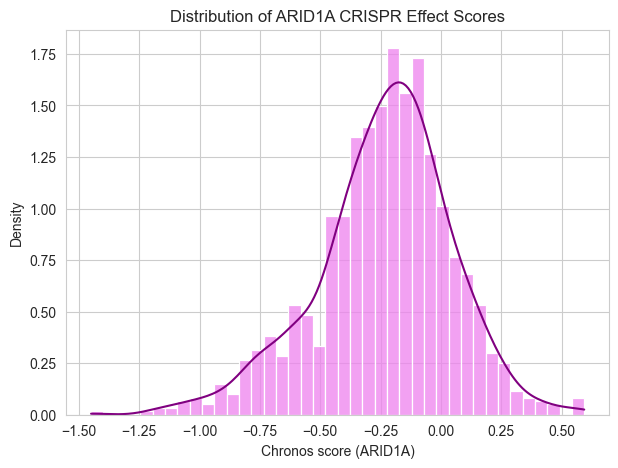

ARID1A Effect Score Summary:
 count    1178.000000
mean       -0.236170
std         0.281660
min        -1.449501
25%        -0.382751
50%        -0.210112
75%        -0.057160
max         0.593313
Name: ARID1A_eff, dtype: float64
Proportion of cell lines with ARID1A_eff < -1: 1.27%


In [62]:
plt.figure(figsize=(7,5))
ax = sns.histplot(data=merged_df, x="ARID1A_eff", bins=40, color='violet', stat='density', edgecolor='white')
sns.kdeplot(data=merged_df, x="ARID1A_eff", color='purple', cut=0, ax=ax)
plt.title("Distribution of ARID1A CRISPR Effect Scores")
plt.xlabel("Chronos score (ARID1A)")
plt.show()
desc_stats = merged_df["ARID1A_eff"].describe()
print("ARID1A Effect Score Summary:\n", desc_stats)
prop_ess = (merged_df["ARID1A_eff"] < -1).mean()
print(f"Proportion of cell lines with ARID1A_eff < -1: {prop_ess:.2%}")

**Interpretation**

- **Chronos scores** measure how knocking out a gene affects cell viability:  
  - **Negative scores** (below 0) imply reduced viability when the gene is knocked out (i.e., the gene is more “essential”).  
  - **Positive scores** (above 0) imply little or no reduction in viability upon knockout, and can sometimes indicate a growth advantage.  

- The **mean ARID1A score** is around **-0.236**, suggesting that in many cell lines, loss of ARID1A impairs cell growth or survival to a modest extent.
- A **small subset** of lines (about 1.27%) have **strongly negative scores (< -1)**, indicating that ARID1A knockout profoundly reduces viability—these cells are highly dependent on ARID1A.
- Another subset of lines clusters around **0 or slightly positive scores**, meaning ARID1A knockout does not meaningfully hinder—or may even promote—growth in those contexts.
- **Biologically**, ARID1A functions in chromatin remodeling and is often considered a tumor suppressor; however, its essentiality is **context-dependent**. Some cell lines require ARID1A to maintain critical regulatory functions, while others can tolerate or even benefit from its loss. This **heterogeneous distribution** illustrates how essentiality varies across different genetic or tissue backgrounds.

### 3.2 Lineage-Specific Analysis
**Why KRAS for this EDA?**

KRAS is one of the most frequently mutated oncogenes (gene that promotes cancerous cell growth) in human cancers—especially in pancreatic, colorectal, and lung lineages. Because of its well-studied role in driving tumor growth, differences in **KRAS CRISPR knockout** effects (Chronos scores) can sometimes be more *striking* or *informative* across different tissue types compared to certain tumor-suppressor genes like ARID1A. This often leads to more pronounced lineage-specific dependencies for KRAS.

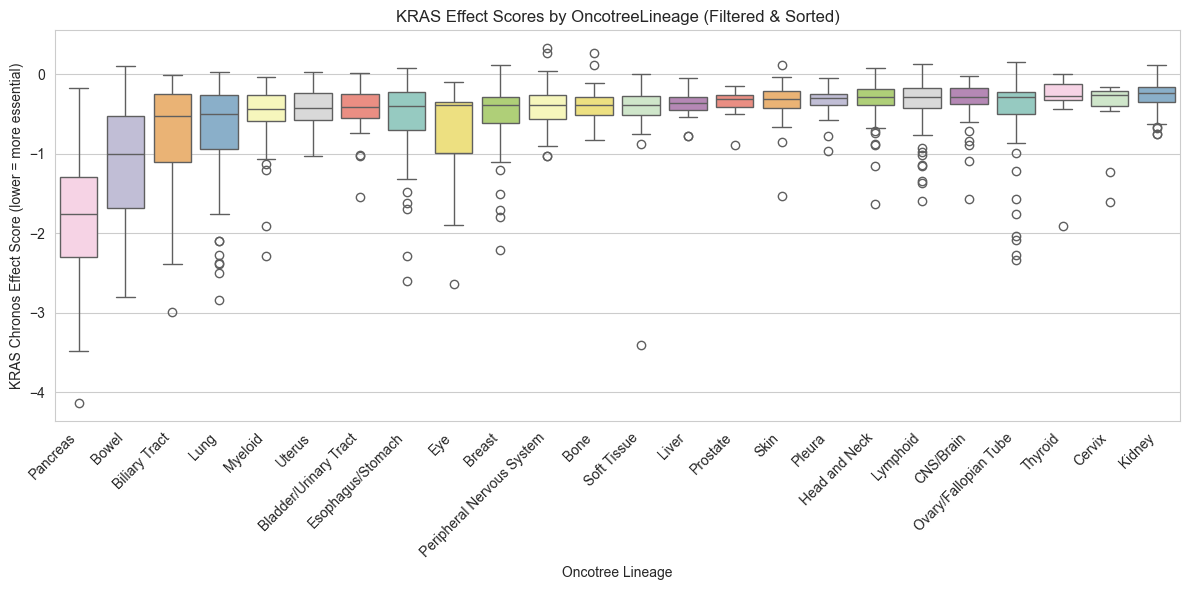

In [63]:
# 1) Filter by minimum sample size, e.g., at least 10 cell lines per lineage
min_sample_size = 10
lineage_counts = merged_df['OncotreeLineage'].value_counts()
lineages_with_enough_cells = lineage_counts[lineage_counts >= min_sample_size].index

# 2) Only keep lineages that have an "interesting" median KRAS_eff
lineage_median = merged_df.groupby('OncotreeLineage')['KRAS_eff'].median()
lineages_of_interest = lineage_median.index

# Combine both filters (sample size & any "interesting" criterion)
selected_lineages = lineages_with_enough_cells.intersection(lineages_of_interest)

# 3) Subset the main DataFrame to only these lineages
lineage_subset = merged_df[merged_df['OncotreeLineage'].isin(selected_lineages)].copy()

# 4) Determine a sorted order by median KRAS_eff, so boxplots go from lowest → highest
sorted_lineages = (
    lineage_subset.groupby('OncotreeLineage')['KRAS_eff']
    .median()
    .sort_values()
    .index
)

# 5) Plot using a palette that can handle multiple categories (e.g., "Set2", "tab20", etc.)
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=lineage_subset,
    x='OncotreeLineage',
    y='KRAS_eff',
    order=sorted_lineages,
    palette=sns.color_palette("Set3", n_colors=len(selected_lineages)),
    hue='OncotreeLineage'
)

plt.title("KRAS Effect Scores by OncotreeLineage (Filtered & Sorted)")
plt.xlabel("Oncotree Lineage")
plt.ylabel("KRAS Chronos Effect Score (lower = more essential)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation**  
- **Pancreatic cell lines** show the most negative median KRAS effect (≈ -1.76), implying that **knocking out KRAS severely impairs cell viability** in these models—consistent with the well-known reliance of pancreatic cancers on KRAS-driven growth.  
- **Bowel (colorectal) lines** also exhibit notably negative KRAS scores, aligning with frequent KRAS mutations and a **strong dependence** on KRAS signaling in colorectal tumors.  
- Lineages with **less negative medians** (e.g., Kidney) suggest **lower KRAS dependency**; their proliferation may hinge on other oncogenic pathways.  
- Overall, the **Chronos score** (where more negative = knockout is more detrimental to the cell) supports a **lineage-specific KRAS essentiality** pattern, reflecting established biological findings that KRAS is a central driver in pancreatic, colorectal, and certain lung cancers but less so in other tissue types.

## 4. Dimensionality Reduction & Clustering

We experimented with both **PCA** and **UMAP** on selected CRISPR effect scores. 

**However, neither method yielded a distinct or clearly interpretable clustering** by lineage or other metadata fields. 
Our resulting projections (not shown here) indicated only broad overlaps among cell lines, 
suggesting that ARID1A (and related genes) do not strongly separate samples in these low-dimensional embeddings.

> *Note: The code for these dimensionality reduction steps is omitted from this version of the notebook. The relevant plots are included in the presentation slides.*

## 5. Statistical Tests & Multi-Omics Associations

This section outlines how we compare gene essentiality scores (e.g., ARID1A effect) across subgroups (mutant vs. wild-type (**control**), high vs. low expression) and check assumptions for parametric tests.

### 5.1 Preliminary Assumption Checks

Before applying parametric tests (e.g., t-test, ANOVA), we test:
- **Normality** using Shapiro–Wilk
- **Homogeneity of variance** using Levene’s test

If either assumption is violated, we use a nonparametric alternative (e.g., Mann–Whitney U).

In [64]:
# Create a binary column indicating whether ARID1A is mutated (>=1) or not
merged_df["ARID1A_mut_binary"] = merged_df["ARID1A_mut"].apply(lambda x: 1 if x >= 1 else 0)

# Checking ARID1A effect in mutant vs. wild-type (control) lines
mut_group = merged_df.loc[merged_df["ARID1A_mut_binary"] == 1, "ARID1A_eff"].dropna()
wt_group  = merged_df.loc[merged_df["ARID1A_mut_binary"] == 0, "ARID1A_eff"].dropna()

# We compute Shapiro–Wilk and Levene’s test
lev_stat, lev_p = levene(mut_group, wt_group)
shap_mut_stat, shap_mut_p = shapiro(mut_group)
shap_wt_stat, shap_wt_p   = shapiro(wt_group)

print(f"Levene’s test p-value = {lev_p:.4g}")
print(f"Shapiro–Wilk p-value (mutant)  = {shap_mut_p:.4g}")
print(f"Shapiro–Wilk p-value (wildtype)= {shap_wt_p:.4g}")

Levene’s test p-value = 0.0008734
Shapiro–Wilk p-value (mutant)  = 4.478e-07
Shapiro–Wilk p-value (wildtype)= 2.59e-08


Assumption checks suggest that normality or variance homogeneity may be violated. Hence, we use the Mann–Whitney U test to compare `ARID1A_eff` between mutant vs. WT lines.

### 5.2 Mann–Whitney U (ARID1A)

The **Mann–Whitney U** (Wilcoxon rank-sum) test is a nonparametric method for **two independent groups**. 
It's useful when we suspect the data (e.g., CRISPR effect scores) may not be normally distributed.

**Question**: 
“Does the distribution of ARID1A effect scores differ between *ARID1A-mutant* lines and *wild-type* lines?”

- **Group 1**: ARID1A-mutant lines (i.e., `ARID1A_mut >= 1`)
- **Group 2**: ARID1A-wild-type lines (`ARID1A_mut == 0`)

We define a new binary column, `ARID1A_mut_binary`, where 1 = mutant (either 1 or 2) and 0 = WT.

Mann–Whitney U test for ARID1A effect (mut vs. wt):
  U-statistic = 85257.000
  p-value     = 9.1666e-11


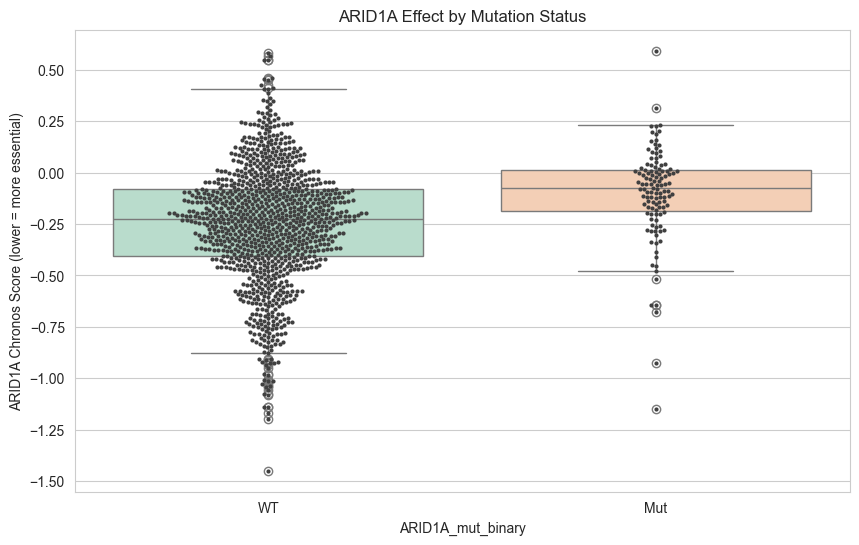

In [65]:
u_stat, u_p = mannwhitneyu(mut_group, wt_group, alternative='two-sided')
print("Mann–Whitney U test for ARID1A effect (mut vs. wt):")
print(f"  U-statistic = {u_stat:.3f}")
print(f"  p-value     = {u_p:.5g}")

# Boxplot
temp_df = merged_df[["ARID1A_eff","ARID1A_mut_binary"]].dropna()
temp_df["ARID1A_mut_binary"] = temp_df["ARID1A_mut_binary"].map({0:"WT",1:"Mut"})

plt.figure(figsize=(10,6))
sns.boxplot(x="ARID1A_mut_binary", y="ARID1A_eff", data=temp_df, hue="ARID1A_mut_binary", palette="Pastel2", dodge=False)
sns.swarmplot(x="ARID1A_mut_binary", y="ARID1A_eff", data=temp_df, color=".25", size=3)

plt.title("ARID1A Effect by Mutation Status")
plt.ylabel("ARID1A Chronos Score (lower = more essential)")
plt.show()

**Interpretation**  
- **Mann–Whitney U** tests the null hypothesis that the two groups (mutant vs. WT) are equally likely to produce higher or lower ARID1A effect scores. A p-value of ~9.17e-11 strongly rejects that null, indicating a **highly significant** difference in ARID1A Chronos scores between **ARID1A-mutant** and **wild-type** cell lines.  
- **Mutant lines** display a **higher (less negative) median** ARID1A effect score, indicating that **knocking out ARID1A has a weaker impact** on viability in cells already harboring damaging ARID1A mutations. In these contexts, ARID1A’s function may be partially compromised to begin with, so further loss confers less additional effect on survival.  
- Conversely, **wild-type lines** show **more negative** ARID1A effect scores, suggesting that **ARID1A is more essential** when it remains fully functional. Knocking it out in WT cells thus causes a greater drop in viability.  
- Overall, this highlights the **context-dependent essentiality** of ARID1A: cells that have already lost part of ARID1A’s tumor-suppressive function appear less reliant on it, whereas cells with intact ARID1A experience a stronger viability defect upon its loss.

### 5.3 Correlations & Tanh Fit

#### 5.3.1 Correlation Matrix

ARID1A-related correlation matrix (Pearson):


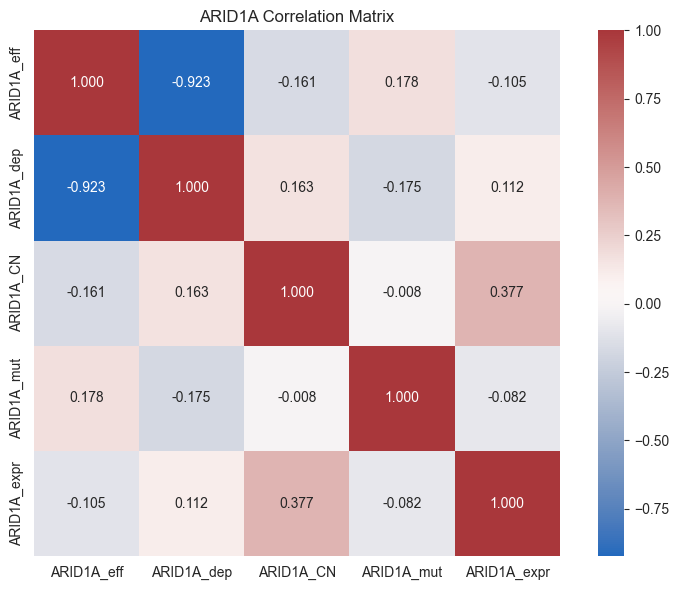

In [66]:
# Extract columns related to ARID1A
cols_arid = [c for c in merged_df.columns if 'ARID1A' in c and not c.endswith("_binary")]
arid1a_df = merged_df[cols_arid].copy()

# Compute Pearson correlation matrix
arid1a_corr_matrix = arid1a_df.corr(method='pearson')

print("ARID1A-related correlation matrix (Pearson):")

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(arid1a_corr_matrix, annot=True, fmt=".3f", cmap="vlag", square=True)
plt.title("ARID1A Correlation Matrix")
plt.tight_layout()
plt.show()

**Interpretation**  
- **`ARID1A_eff` vs. `ARID1A_dep`** has a strong negative correlation (r ~ −0.923).  
  - Interpreting Chronos effect (more negative = more essential) vs. dependency (closer to 1 = more dependent) often leads to an inverse relationship.
- **`ARID1A_eff` vs. `ARID1A_expr`** is weaker (r ~ −0.105), indicating that ARID1A expression levels do not strongly predict how essential ARID1A is in most lines.

#### 5.3.2 Nonlinear Relationship (Tanh Model)

A **strong negative correlation** $(\approx −0.92)$ suggests these scores track similar biology but on different scales. To capture their *saturating* relationship, we fit a **hyperbolic tangent (tanh)** model:

$$
\text{ARID1A}_{\mathrm{dep}} \;=\; a\,\tanh\left(b\,\text{ARID1A}_{\mathrm{eff}} + c\right)\;+\;d.
$$

This accounts for how *very negative* ARID1A effect values (high essentiality) map to near-max dependency. Such nonlinear fits reflect approaches used by DepMap, where logistic/tanh transformations map CRISPR effect scores onto probabilities of dependency.<sup>[1,2]</sup>

**Interpretation**  
- Saturation at high essentiality: effect < −1 → dependency ≈ 1.  
- Inflection point marks the transition from low to high ARID1A dependency.  

<sup>**References**</sup>  
1. [Dempster, J. (2021). *Understanding the differences between CERES and Chronos DepMap data.*](https://cancerdatascience.org/blog/posts/ceres-chronos/)  
2. [DepMap Genetic Dependencies FAQ](https://forum.depmap.org/t/depmap-genetic-dependencies-faq/131)

Best-fit parameters for tanh model: [ 0.49957826 -3.63477571 -1.59957527  0.48380229]


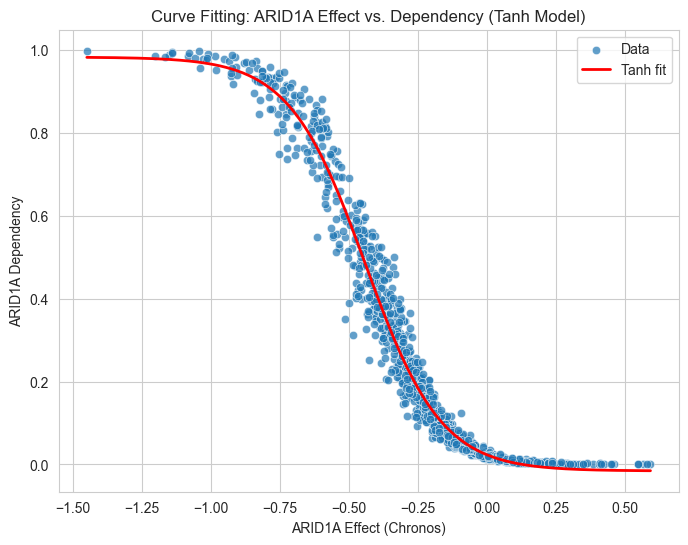

In [67]:
# Define the tanh model function
def tanh_model(x, a, b, c, d):
    """
    Model: a * tanh(b * x + c) + d
    a and d scale the output range to match dependency scores (0-1).
    b and c control the steepness and inflection point.
    """
    return a * np.tanh(b * x + c) + d

# Extract the data: x = ARID1A_eff, y = ARID1A_dep from your DataFrame 'arid1a_df'
x_data = arid1a_df["ARID1A_eff"].values
y_data = arid1a_df["ARID1A_dep"].values

# Fit the tanh model to the data
popt_tanh, pcov_tanh = curve_fit(tanh_model, x_data, y_data, maxfev=10000)
print("Best-fit parameters for tanh model:", popt_tanh)

# Generate x values for plotting the fitted curve
x_fit = np.linspace(np.min(x_data), np.max(x_data), 200)
y_fit_tanh = tanh_model(x_fit, *popt_tanh)

# Plot the data and the fitted tanh curve
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_data, y=y_data, alpha=0.7, label="Data")
plt.plot(x_fit, y_fit_tanh, color="red", lw=2, label="Tanh fit")
plt.xlabel("ARID1A Effect (Chronos)")
plt.ylabel("ARID1A Dependency")
plt.title("Curve Fitting: ARID1A Effect vs. Dependency (Tanh Model)")
plt.legend()
plt.show()

The relationship appears to be modeled well by the formula below:
$$
\mathrm{ARID1A}_{\mathrm{dep}} \approx 0.4996\tanh(-3.6348\,\mathrm{ARID1A}_{\mathrm{eff}} - 1.5996) + 0.4838.
$$

---

## 6. Integrating Multi-Omics with Metadata to Predict and Cluster Gene Dependencies

In this section, we expand upon our previous machine-learning approach by incorporating **both** the **omics data** (expression, copy number, mutations for each of our 30 genes) **and** cell-line-level **metadata** (OncotreeLineage, ModelType, PatientTreatment, etc.). Our goal is twofold:

1. **Predict** continuous gene dependency scores (e.g., $\text{KRAS}_\text{dep}$) more accurately by leveraging all relevant features.
2. **Identify** subgroups of cell lines (via clustering) that might share similar multi-omics profiles and dependencies—potentially reflecting distinct biological or clinical subtypes.

### 6.1 Data Preparation: Metadata and Omics Integration

Below, we illustrate how we **merged** the DepMap CRISPR data with the **Model.csv** metadata, then **auto-detected** numeric vs. categorical fields. We also did the following:

- **One-hot-encoded** categorical fields (e.g. OncotreeLineage, OncotreeSubtype, etc.).  
- **Filled missing** numeric columns with the median.  
- **Dropped** extraneous columns such as `PatientID`, `CellLineName`, `RRID`, etc.  
- **Scaled** numeric columns via `StandardScaler`.  

The result is `df_meta_enc`: a DataFrame of shape $(1178, 1357)$, which now contains:
- Core omics features (`XXX_expr`, `XXX_CN`, `XXX_mut`) for 30 genes,  
- One-hot-encoded metadata features (like `OncotreeLineage_Pancreas = True/False`),  
- Additional numeric fields (e.g., Age, COSMICID) scaled appropriately,  
- The target columns `XXX_dep` for each gene’s dependency (0–1 scale).

In [68]:
cols_to_drop = ['PatientID','CellLineName','StrippedCellLineName','RRID','CatalogNumber',
                'SangerModelID','CCLEName']
merged_df.drop(cols_to_drop, axis='columns', inplace=True)

In [69]:
# Automatic detection of numeric vs. categorical
MAX_UNIQUE_FOR_CATEGORICAL = 200
categorical_fields, numeric_fields = [], []
for c in merged_df.columns:
    if c == "ModelID" or c.endswith("_dep") or c.endswith("_eff"):
        continue
    if any(c.endswith(x) for x in ["_expr","_mut","_CN"]):
        continue

    unique_vals = merged_df[c].dropna().unique()
    if len(unique_vals) == 0: 
        continue
    if pd.api.types.is_numeric_dtype(merged_df[c]):
        numeric_fields.append(c)
    else:
        if len(unique_vals) <= MAX_UNIQUE_FOR_CATEGORICAL:
            categorical_fields.append(c)
        # else skip if too many unique values

# Fill missing and one-hot encode
for cat in categorical_fields:
    merged_df[cat] = merged_df[cat].fillna("Unknown")
for numcol in numeric_fields:
    merged_df[numcol] = merged_df[numcol].fillna(merged_df[numcol].median())

df_meta_enc = pd.get_dummies(merged_df, columns=categorical_fields, drop_first=False)

# Scale numeric metadata columns
scaler = StandardScaler()
for numcol in numeric_fields:
    if numcol in df_meta_enc.columns:
        df_meta_enc[numcol] = scaler.fit_transform(df_meta_enc[[numcol]])

print("Shape after metadata encoding:", df_meta_enc.shape)
df_meta_enc.head(3)

Shape after metadata encoding: (1178, 1357)


,ModelID,ALK_eff,APC_eff,ARID1A_eff,BRAF_eff,BRCA1_eff,BRCA2_eff,CDK4_eff,CDK6_eff,CDKN2A_eff,...,ModelSubtypeFeatures_Unknown,ModelSubtypeFeatures_basal TNBC,ModelSubtypeFeatures_basal_A HER2+,ModelSubtypeFeatures_basal_A TNBC,ModelSubtypeFeatures_basal_B TNBC,ModelSubtypeFeatures_hbs_antigen_carrier,"ModelSubtypeFeatures_luminal ER+, HER2+","ModelSubtypeFeatures_luminal ER+, PR+, HER2+","ModelSubtypeFeatures_luminal ER, PR+",ModelSubtypeFeatures_luminal TNBC
0,ACH-000001,-0.103312,-0.816367,-0.706872,-0.278221,-0.433829,-0.103624,-0.307988,-0.007049,0.001419,...,True,False,False,False,False,False,False,False,False,False
1,ACH-000004,-0.102166,-0.743033,-0.493226,0.096099,-0.309678,-0.334036,-0.714847,-0.530992,0.187944,...,True,False,False,False,False,False,False,False,False,False
2,ACH-000005,0.018104,-0.232277,-0.251699,0.141998,0.172385,-0.345666,-1.066063,-1.394510,0.047930,...,True,False,False,False,False,False,False,False,False,False


### 6.2 Single-Gene Regression (`KRAS_dep`) with Full Features

#### 6.2.1 Constructing the Feature Matrix

We gather **all** omics columns (for the 30 genes) plus the newly encoded **metadata** columns. We skip `*_dep`, `*_eff`, and `ModelID`, resulting in a total of **1,298** feature columns:

In [70]:
# Identify omics columns for our 30 genes
all_genes = [
    "TP53","EGFR","KRAS","BRCA1","BRCA2","CDKN2A","PTEN","MYC","PIK3CA","RB1","BRAF",
    "APC","CTNNB1","SMAD4","ERBB2","ALK","MET","NOTCH1","NOTCH2","NOTCH3","NOTCH4",
    "NF1","NF2","CDK4","CDK6","IDH1","IDH2","ARID1A","CTCF"
]

omics_feature_cols = []
for g in all_genes:
    for suffix in ["_expr","_mut","_CN"]:
        col = f"{g}{suffix}"
        if col in df_meta_enc.columns:
            omics_feature_cols.append(col)

# Skip dep/eff/ModelID
dep_eff_cols = [c for c in df_meta_enc.columns if c.endswith("_dep") or c.endswith("_eff")]
skip_cols = set(omics_feature_cols + dep_eff_cols + ["ModelID"])

# Everything else is 'metadata'
meta_feature_cols = [c for c in df_meta_enc.columns if c not in skip_cols]
full_feature_cols = omics_feature_cols + meta_feature_cols

print("Omics feature count:", len(omics_feature_cols))
print("Metadata feature count:", len(meta_feature_cols))
print("Total feature columns:", len(full_feature_cols))

Omics feature count: 86
Metadata feature count: 1212
Total feature columns: 1298



Hence, we combine **86 omics columns** (expression, CN, mutation) with **1,212 encoded metadata columns** (lineage, stage, etc.).

#### 6.2.2 Fitting the Random Forest Model for `KRAS_dep`

We next isolate rows that have a non-null value for `KRAS_dep`, split into training/testing (80/20), and train a `RandomForestRegressor`.

In [71]:
target_gene = "KRAS"
target_col = f"{target_gene}_dep"

df_reg = df_meta_enc.dropna(subset=[target_col]).copy()
X = df_reg[full_feature_cols]
y = df_reg[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Random Forest for {target_gene}_dep (with metadata + omics):")
print(f"  MSE = {mse:.4f}")
print(f"  R^2 = {r2:.4f}")

Random Forest for KRAS_dep (with metadata + omics):
  MSE = 0.0781
  R^2 = 0.2637


**Interpretation**

- We achieve an $R^2 \approx 0.26$. Although not extremely high, it’s **higher** than we often see with simpler gene-only features. This suggests the inclusion of metadata (e.g. OncotreeLineage, patient/tumor attributes) **improves** our ability to explain variability in KRAS dependency across cell lines.

#### 6.2.3 Top Features for `KRAS_dep`

We examine the **feature importances** from the trained random forest:


In [72]:
importances = rf.feature_importances_
feat_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]

print("\nTop 15 Features for KRAS_dep (with full metadata):")
for i in range(15):
    idx = sorted_idx[i]
    print(f"  {feat_names[idx]:30s} => {importances[idx]:.4f}")


Top 15 Features for KRAS_dep (with full metadata):
  KRAS_CN                        => 0.0911
  OncotreeLineage_Pancreas       => 0.0532
  OncotreeLineage_Bowel          => 0.0271
  OncotreePrimaryDisease_Colorectal Adenocarcinoma => 0.0254
  MET_expr                       => 0.0223
  EGFR_CN                        => 0.0217
  PTEN_CN                        => 0.0211
  KRAS_expr                      => 0.0210
  NOTCH2_CN                      => 0.0204
  IDH2_expr                      => 0.0188
  IDH1_expr                      => 0.0178
  CDKN2A_expr                    => 0.0150
  IDH2_CN                        => 0.0143
  CDKN2A_CN                      => 0.0140
  NOTCH2_expr                    => 0.0138


**Interpretation**

1. **`KRAS_CN`** (copy number) is the top single feature, which makes intuitive sense: amplifications or deletions of the KRAS locus can drastically impact how essential KRAS is when knocked out.  
2. **Lineage**: Pancreatic (`OncotreeLineage_Pancreas`) and Bowel (colorectal) lineages strongly predict KRAS dependency. This is **consistent** with known biology: KRAS is often crucial in **pancreatic** adenocarcinomas and in many **colorectal** tumors.  
3. **`KRAS_expr`** also appears high, further supporting the direct link between the gene’s expression and its essentiality.  
4. Other interesting top features:  
   - **`NOTCH2_CN`** and **`EGFR_CN`**: This might reflect certain co-amplifications or dependencies with RTK (Receptor Tyrosine Kinase) pathways.  
   - **`MET_expr`** and **`PTEN_CN`** might indicate synergy with other major signaling axes (e.g., PI3K/AKT for PTEN).

Overall, these **metadata + omics** results confirm that:

- KRAS’s essentiality is strongly **lineage-dependent**, especially in pancreatic and bowel cancers.  
- Additional copy number changes in other oncogenes or tumor suppressors can modulate how reliant the cell line is on KRAS function.

### 6.3 Multi-Output Regression for Multiple Genes

Instead of focusing on just KRAS, we can simultaneously predict dependency for multiple genes (e.g., APC, ARID1A, BRCA1, etc.) with enough variance. We:

1. Filtered to only those `_dep` columns where the standard deviation was $\geq 0.25$ (to avoid nearly constant columns).  
2. Built a `MultiOutputRegressor` with a `RandomForestRegressor` inside.  
3. Computed the $R^2$ and MSE for each gene.

#### 6.3.1 Selecting Genes


In [73]:
# 1) Identify the _dep columns that have enough variance
dep_cols = [c for c in df_meta_enc.columns if c.endswith("_dep")]
dep_stds = df_meta_enc[dep_cols].std(skipna=True)

# For demonstration, let's pick columns with std >= 0.25
interesting_deps = dep_stds[dep_stds >= 0.25].index.tolist()
print("Retaining these dep columns:", interesting_deps)

# 2) Build X (features) and Y (targets)
#    We skip any row that doesn't have values for *all* interesting_deps.
df_multi = df_meta_enc.dropna(subset=interesting_deps).copy()

X_multi = df_multi[full_feature_cols]  # same feature set used for single-gene
Y_multi = df_multi[interesting_deps]

print("X_multi shape:", X_multi.shape)
print("Y_multi shape:", Y_multi.shape)

Retaining these dep columns: ['APC_dep', 'ARID1A_dep', 'BRCA1_dep', 'BRCA2_dep', 'CDK4_dep', 'CDK6_dep', 'CTNNB1_dep', 'EGFR_dep', 'ERBB2_dep', 'KRAS_dep', 'PIK3CA_dep']
X_multi shape: (1178, 1298)
Y_multi shape: (1178, 11)


#### 6.3.2 Train/Test Split & Model Training

In [74]:
# 3) Train/test split (crucial to avoid data leakage!)
X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(
    X_multi, Y_multi, test_size=0.2, random_state=42
)

# 4) Multi-output RF
multi_rf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=100, random_state=42)
)
multi_rf.fit(X_train_m, Y_train_m)

# 5) Predict on the test set
Y_pred_m = multi_rf.predict(X_test_m)

#### 6.3.3 Per-Gene $R^2$ and MSE

In [75]:
# Evaluate per gene
results = []
for i, dep_name in enumerate(Y_multi.columns):
    # Y_test_m.iloc[:, i] is the true values for gene i in test set
    # Y_pred_m[:, i] is the predicted values for that gene
    r2_val = r2_score(Y_test_m.iloc[:, i], Y_pred_m[:, i])
    mse_val = mean_squared_error(Y_test_m.iloc[:, i], Y_pred_m[:, i])
    results.append({"Gene": dep_name.replace("_dep",""), "R2": r2_val, "MSE": mse_val})

results_df = pd.DataFrame(results).sort_values("R2", ascending=False)
display(results_df)

avg_r2 = results_df["R2"].mean()
avg_mse = results_df["MSE"].mean()
print(f"\nAverage R^2 across these genes: {avg_r2:.4f}")
print(f"Average MSE across these genes: {avg_mse:.4f}")

,Gene,R2,MSE
6,CTNNB1,0.583294,0.029673
5,CDK6,0.458090,0.078911
8,ERBB2,0.362204,0.059297
7,EGFR,0.360305,0.072325
9,KRAS,0.263722,0.078079
4,CDK4,0.220245,0.056691
10,PIK3CA,0.172110,0.080869
1,ARID1A,0.061271,0.074724
3,BRCA2,0.047587,0.084079
0,APC,0.044288,0.068099



Average R^2 across these genes: 0.2374
Average MSE across these genes: 0.0702


**Interpretation**
- `CTNNB1_dep` is apparently the easiest to predict ($R^2 \approx 0.58$), while `BRCA1_dep` is very challenging ($R^2 \approx 0.038$).
- **CTNNB1** encodes $\beta$-catenin in the Wnt pathway; the high $R^2$ might indicate that certain metadata + omics features (e.g., lineage, co-mutations in APC or other Wnt regulators) strongly dictate CTNNB1 dependency.  
- **CDK6** also has a fairly high $R^2$. Possibly, high expression or gene amplification in certain lineages (e.g., leukemias, lymphomas, or breast cancers) correlates well with CDK6 essentiality.  
- Genes with lower $R^2$ (like **APC** or **BRCA1/2** and **ARID1A**) might have more complex patterns of essentiality not easily captured by linear/categorical metadata or single-gene omics alone. Alternatively, these tumor suppressors might be partially mutated or partially lost, making their dependencies less uniformly predicted by the available features.  

**Takeaway**: 
- This approach reveals that some gene dependencies (CTNNB1, CDK6, EGFR, etc.) are more systematically associated with metadata/omics factors than others. This can point to new hypotheses about the **regulatory or pathway-level** contexts that drive essentiality for those genes.

### 6.4 Unsupervised Clustering of Cell Lines

Here, we investigate whether cell lines can be grouped in an unsupervised manner using both **metadata** and **omics** features. The steps are:

1. **Scale** the expression and copy-number columns (via `StandardScaler`).
2. **Exclude** columns related to CRISPR (`_dep`, `_eff`), plus `ModelID`.
3. **Dimensionality Reduction**: Apply PCA to 2 components (PC1, PC2).
4. **KMeans Clustering**: Run K=5 on the resulting 2D PCA representation.

This produces five clusters, each containing subsets of cell lines that may share similar multi-omics profiles.

=== Cluster Sizes ===
Cluster
0    356
1    365
2    207
3     44
4    206
Name: count, dtype: int64 

=== Top 5 lineages per cluster ===

Cluster 0:
OncotreeLineage
Lymphoid                     63
Skin                         46
Peripheral Nervous System    40
Myeloid                      31
Bone                         26

Cluster 1:
OncotreeLineage
Lung                    68
CNS/Brain               31
Uterus                  25
Ovary/Fallopian Tube    24
Head and Neck           23

Cluster 2:
OncotreeLineage
CNS/Brain      41
Lung           25
Lymphoid       21
Bone           19
Soft Tissue    15

Cluster 3:
OncotreeLineage
Bowel                21
Esophagus/Stomach     6
Skin                  2
Lung                  2
Myeloid               2

Cluster 4:
OncotreeLineage
Head and Neck        47
Esophagus/Stomach    35
Pancreas             28
Bowel                20
Lung                 19


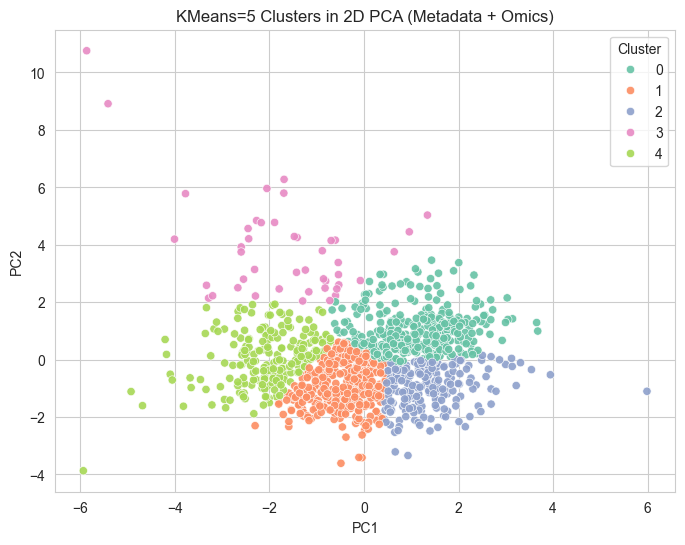

In [76]:
# Identify expression + CN feature columns
expr_cn_cols = [c for c in omics_feature_cols if (c.endswith("_expr") or c.endswith("_CN"))]

# Copy df_meta_enc to df_cluster
df_cluster = df_meta_enc.copy()

# Attempt to preserve OncotreeLineage if it exists in merged_df
if "OncotreeLineage" in merged_df.columns:
    df_cluster["OncotreeLineage"] = merged_df["OncotreeLineage"]

# Scale just the expression/CN columns
scaler_omics = StandardScaler()
df_cluster[expr_cn_cols] = scaler_omics.fit_transform(df_cluster[expr_cn_cols])

# Exclude dep/eff/ModelID/OncotreeLineage from the clustering feature set
exclude_cols = [c for c in df_cluster.columns if c.endswith("_dep") or c.endswith("_eff")]
exclude_cols.append("ModelID")
cluster_cols = [c for c in df_cluster.columns if c not in exclude_cols and c not in ["OncotreeLineage"]]

# Drop any columns that are entirely NaN
X_cluster = df_cluster[cluster_cols].dropna(axis='columns').values

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)

# KMeans with k=5
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Create a DataFrame for plotting
df_pca = pd.DataFrame({"PC1": X_pca[:, 0],
                       "PC2": X_pca[:, 1],
                       "Cluster": clusters},
                      index=df_cluster.index)

# Attach OncotreeLineage if available
df_pca["OncotreeLineage"] = df_cluster["OncotreeLineage"]

# Build crosstab of cluster vs lineage
lineage_ct = pd.crosstab(df_pca["Cluster"], df_pca["OncotreeLineage"])

# 1) Print cluster sizes (how many lines in each cluster):
print("=== Cluster Sizes ===")
cluster_counts = df_pca["Cluster"].value_counts().sort_index()
print(cluster_counts, "\n")

# 2) Filter out columns (lineages) that appear fewer than a threshold (e.g., 5 total lines)
threshold = 5
filtered_cols = lineage_ct.columns[lineage_ct.sum(axis=0) >= threshold]
filtered_ct = lineage_ct[filtered_cols]

# 3) Show top 5 lineages per cluster in a friendlier manner
print("=== Top 5 lineages per cluster ===")
for c in sorted(df_pca["Cluster"].unique()):
    cluster_slice = df_pca.loc[df_pca["Cluster"] == c, "OncotreeLineage"]
    top_lineages = cluster_slice.value_counts().head(5)
    print(f"\nCluster {c}:")
    print(top_lineages.to_string())
    
# Plot the scatter with PC1 vs PC2 colored by cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="Cluster",
    data=df_pca, palette="Set2", alpha=0.9
)
plt.title(f"KMeans={k} Clusters in 2D PCA (Metadata + Omics)")
plt.show()

**Interpretation**

- **Cluster Sizes**: Clusters 0 and 1 each contain over 300 lines, whereas cluster 3 is much smaller (44 lines total), suggesting distinct subpopulations.
- **Lineage Highlights**:
  - Cluster 0 is enriched in Lymphoid, Skin, and Myeloid lineages.
  - Cluster 1 features many Lung, CNS/Brain, Uterus, and Ovary lines.
  - Cluster 2 also captures CNS/Brain, Lung, and Bone lineages.
  - Cluster 3 is smaller, dominated by Bowel lineage.
  - Cluster 4 contains numerous Head/Neck, Stomach, and Pancreatic lines.
- **Takeaway**: Some lineages cluster together, indicating shared omics/metadata patterns. However, these clusters do **not** strictly map to a single lineage.

**Related Work & References**  

Multi-omics clustering approaches and gene essentiality predictions have been actively studied. For example, **Krill-Burger et al.** ([PMC10464129](https://pmc.ncbi.nlm.nih.gov/articles/PMC10464129)) demonstrated integrating multi-omics with CRISPR and RNAi datasets for improved dependency mapping, and **Chiu et al.** ([PMC8378822](https://pmc.ncbi.nlm.nih.gov/articles/PMC8378822)) introduced a deep-learning model (DeepDEP) for multi-omics essentiality predictions. These studies highlight how PCA or other dimensionality reductions (UMAP, t-SNE) can reveal subtypes within large-scale DepMap data. While our clustering uses a simpler pipeline (standard PCA + k-means), it still serves as a useful exploratory tool to identify broad subgroups in a multi-omics context.

## 7. Conclusions & Next Steps

We have performed a pipeline integrating **CRISPR effect/dependency** data, **mutation**, **copy-number**, and **expression** data, plus optional external references. This reveals key insights into which genes are essential, and in which contexts.

### 7.1 Biological Validation
- The final step in any in silico CRISPR screen is experimental validation. If a gene emerges as conditionally essential (say, only in PTEN-mutant lines), test that gene knockout in isogenic cell lines with and without PTEN mutation.
- Alternatively, use base editors to mutate specific hotspots to confirm the essential region of a gene's coding sequence.

### 7.2 Common Pitfalls & How to Avoid Them
1. **Addressing Copy-Number Artifacts**: CRISPR screens can artificially identify high-copy genes as "essential" due to multiple cut sites. DepMap’s Chronos algorithm corrects for these biases ([Meyers et al., Nature Genetics 2017](https://doi.org/10.1038/ng.3984)). We therefore use Chronos-corrected scores (CRISPRGeneEffect.csv) to limit CN confounds. If you have raw log-fold changes, consider implementing CERES or Chronos yourself or removing genes with extreme amplifications from your analysis.
2. **Batch Effects**: DepMap screens over multiple years; unify or correct if necessary.
3. **Data Mismatch**: Genes named differently (e.g., `ARID1A` vs. `ARID1A (7157)`). Consistent gene naming is crucial.
4. **Small Sample Size for Rare Cancers**: Subtype-specific essentialities may be underpowered.
5. **Class Imbalance**: Certain genes are essential in only a minority of cell lines, or certain subtypes (e.g., mutant vs. wild-type) have vastly different sample sizes. This can cause models to ignore the minority class. Consider techniques like **class weighting**, **oversampling**, or **group-specific thresholds** to improve recall of rare but important subgroups.

### 7.3 References

1. **DepMap Data Portal**: [https://depmap.org/portal/](https://depmap.org/portal/)  
2. **CERES**: Meyers RM *et al.* (2017). *Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells.*  
   *Nat Genet* 49, 1779–1784. [DOI:10.1038/ng.3984](https://doi.org/10.1038/ng.3984)  
3. **Chronos**: Dempster JM *et al.* (2021). *Chronos: a cell population dynamics model of CRISPR experiments that improves inference of gene fitness effects.*  
   *Genome Biol* 22, 343. [DOI:10.1186/s13059-021-02540-7](https://doi.org/10.1186/s13059-021-02540-7)  
4. **BioGRID ORCS**: [https://orcs.thebiogrid.org/](https://orcs.thebiogrid.org/)  
5. **Base Editor Screens**: Gaudelli NM *et al.* (2017). *Programmable base editing of A•T to G•C in genomic DNA without DNA cleavage.*  
   *Nature* 551, 464–471. [DOI:10.1038/nature24644](https://doi.org/10.1038/nature24644)  
6. Additional references in the text above.

**Thank you for following along with this multi-omics CRISPR integration tutorial!**